# Real data analysis in Python

Konrad Brodzik

20 April 2023

### Workshop format

Live demo, but here's a link to the data and some setup instructions if you'd like to follow along: https://github.com/Kondziowy/data-analysis-workshop

### Problem statement

Sally: "The website is loading slowly, can you fix it?"

Me: "What do you mean?"

Sally: "Umm, it loads slower than last week"

### App - description

- Web application - internal document management system
- 200 daily active users

![System diagram](img\system-diagram.png "Diagram" )

### Our goals

1. Parse data that's available to us
1. De-noise the data
2. Have a quantitative measure of what's going wrong
3. Correlate different sources of data to find out the root cause of the problem
4. Aggregate data so we can use it for future failure detection

### Front End

What does it do? Serves static files (Javascript, images), forwards other requests to Gunicorn.

Example log:
```
127.0.0.1 - - [01/Apr/2023:11:27:40 +0000] "GET /index.html HTTP/1.1" 200 1200 0.002617
127.0.0.1 - - [01/Apr/2023:11:27:45 +0000] "GET /images/logo.png HTTP/1.1" 200 15734 0.007353
127.0.0.1 - - [01/Apr/2023:11:28:10 +0000] "POST /login HTTP/1.1" 302 - 0.014992
127.0.0.1 - - [01/Apr/2023:11:29:05 +0000] "GET /dashboard HTTP/1.1" 200 4369 0.100576
127.0.0.1 - - [01/Apr/2023:11:30:20 +0000] "GET /orders HTTP/1.1" 200 3520 0.006817
```

### Possible approaches

- Dedicated library?
- Using find and split
- Regular Expressions

In [73]:
import re
from collections import defaultdict

# log_file = open('data\\access.log.small', 'r')  # replace with the path to your log file
log_file = open('apache.log.big', 'r')  # replace with the path to your log file

log_pattern = re.compile(
    r'(?P<IP>\d+\.\d+\.\d+\.\d+)\s-\s-\s\[(?P<Date>.*?)\]\s\"(?P<Method>POST|GET) (?P<Request>.*?) HTTP/1.1\"\s(?P<StatusCode>\d+)\s(?P<DataSize>\d+)\s(?P<RequestTime>.*?)$')

data_by_column = defaultdict(list)
for line in log_file:
    match = log_pattern.match(line)
    if match is None:
        continue  # skip lines that don't match the pattern
    for column, value in match.groupdict().items():
        data_by_column[column].append(value)

log_file.close()

In [74]:
print(data_by_column)

defaultdict(<class 'list'>, {'IP': ['127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '127.0.0.1', '1

In [75]:
import pandas as pd

front_end_requests = pd.DataFrame(
  data_by_column
)
front_end_requests.head()

,IP,Date,Method,Request,StatusCode,DataSize,RequestTime
0,127.0.0.1,03/Apr/2020:12:00:01 +0000,POST,/login,200,89758,0.264581
1,127.0.0.1,03/Apr/2020:12:00:01 +0000,GET,/static/jquery-3.3.1.slim.min.js,404,78887,0.390575
2,127.0.0.1,03/Apr/2020:12:00:01 +0000,GET,/static/jquery-3.3.1.slim.min.js,200,59710,0.663279
3,127.0.0.1,03/Apr/2020:12:00:02 +0000,GET,/,200,51696,0.212686
4,127.0.0.1,03/Apr/2020:12:00:02 +0000,GET,/static/jquery-3.3.1.slim.min.js,200,65509,0.302621


Step 1 - let's figure out how many requests of what kind we're getting

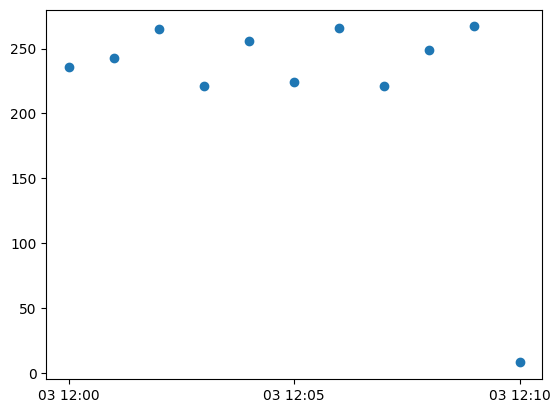

In [76]:
# TODO: Explain index and columns

import matplotlib.pyplot as plt
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes
front_end_requests['Date'] = pd.to_datetime(front_end_requests['Date'], format="%d/%b/%Y:%H:%M:%S %z")
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
# 'T' is for minutes, 'S' for seconds
grouped_requests = front_end_requests.groupby([pd.Grouper(key='Date', axis=0, freq='T')]).count() # , 'Request', 'Method'
grouped_requests.head()
# grouped_requests.index.get_level_values('Date')
# Subsequent keys in a MultiIndex are called levels - https://pandas.pydata.org/docs/reference/api/pandas.MultiIndex.html
plt.plot(grouped_requests.index.get_level_values('Date'), grouped_requests['StatusCode'], 'o')
# TODO: add labels, improve date formatting

### Front end logs - summary
- 

### Back End

What does it do? Processes business logic, wraps database requests.

Example log:
```
[2022-04-01 13:37:00 +0000] [12345] [ellen] [api.py:85] [INFO] GET /documents?page=X&per_page=Y&filter=Z 200 3520 0.006817
[2022-04-01 13:37:00 +0000] [12345] [] [api.py:86] [INFO] Recording operation GET from user ellen
[2022-04-01 13:37:00 +0000] [12345] [ellen] [api.py:85] [INFO] GET /users 200 3128 0.006817
```